In [1]:
import os
import sys
import json
import argparse
import numpy as np
import math
from einops import rearrange
import time
import random
import string
import h5py
from tqdm import tqdm
import webdataset as wds

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import transforms
from accelerate import Accelerator, DeepSpeedPlugin

from generative_models.sgm.modules.encoders.modules import FrozenOpenCLIPImageEmbedder
from models import GNet8_Encoder

import evaluate
import os
from sentence_transformers import SentenceTransformer, util
from transformers import AutoProcessor, CLIPModel, AutoTokenizer

# tf32 data type is faster than standard float32
torch.backends.cuda.matmul.allow_tf32 = True

# custom functions #
import utils

### Multi-GPU config ###
local_rank = os.getenv('RANK')
if local_rank is None: 
    local_rank = 0
else:
    local_rank = int(local_rank)
print("LOCAL RANK ", local_rank)  

accelerator = Accelerator(split_batches=False, mixed_precision="fp16") # ['no', 'fp8', 'fp16', 'bf16']

print("PID of this process =",os.getpid())
device = accelerator.device
print("device:",device)
world_size = accelerator.state.num_processes
distributed = not accelerator.state.distributed_type == 'NO'
num_devices = torch.cuda.device_count()
if num_devices==0 or not distributed: num_devices = 1
num_workers = num_devices
print(accelerator.state)

print("distributed =",distributed, "num_devices =", num_devices, "local rank =", local_rank, "world size =", world_size)
print = accelerator.print # only print if local_rank=0

/admin/home-mihirneal/miniconda3/envs/mindeye/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/admin/home-mihirneal/miniconda3/envs/mindeye/lib/python3.10/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


LOCAL RANK  0
PID of this process = 4027640
device: cuda
Distributed environment: NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: fp16

distributed = False num_devices = 1 local rank = 0 world size = 1


In [2]:
# if running this interactively, can specify jupyter_args here for argparser to use
if utils.is_interactive():
    model_name = "re_cont_blur"
    subj = 1
    data_path = "/weka/proj-fmri/shared/mindeyev2_dataset"
    print("model_name:", model_name)

    jupyter_args = f"--model_name={model_name} --subj={subj} --data_path={data_path}"
    print(jupyter_args)
    jupyter_args = jupyter_args.split()
    
    from IPython.display import clear_output # function to clear print outputs in cell
    %load_ext autoreload 
    # this allows you to change functions in models.py or utils.py and have this notebook automatically update with your revisions
    %autoreload 2 

model_name: re_cont_blur
--model_name=re_cont_blur --subj=1 --data_path=/weka/proj-fmri/shared/mindeyev2_dataset


In [3]:
parser = argparse.ArgumentParser(description="Model Training Configuration")
parser.add_argument(
    "--model_name", type=str, default="testing",
    help="name of model, used for ckpt saving and wandb logging (if enabled)",
)
parser.add_argument(
    "--data_path", type=str, default="/weka/proj-fmri/shared/mindeyev2_dataset",
    help="Path to where NSD data is stored / where to download it to",
)
parser.add_argument(
    "--subj",type=int, default=1, choices=[1,2,3,4,5,6,7,8],
    help="Evaluate on which subject?",
)
parser.add_argument(
    "--seed",type=int,default=42,
)
if utils.is_interactive():
    args = parser.parse_args(jupyter_args)
else:
    args = parser.parse_args()

# create global variables without the args prefix
for attribute_name in vars(args).keys():
    globals()[attribute_name] = getattr(args, attribute_name)
    
# seed all random functions
utils.seed_everything(seed)

# Evals

In [4]:
all_captions = torch.load(f"evals/all_captions.pt")
# all_predcaptions = torch.load(f"evals/{model_name}/{model_name}_all_predcaptions.pt")
# all_git_generated_captions = torch.load(f"/weka/proj-fmri/shared/Mindeyev2_s3/all_git_generated_captions.pt")

In [5]:
all_images = torch.load(f"evals/all_images.pt")
# all_images = torch.load(f"test_image.pt")
all_clipvoxels = torch.load(f"evals/{model_name}/{model_name}_all_clipvoxels.pt")

# all_recons = torch.load(f"evals/{model_name}/{model_name}_all_recons.pt")
# # all_recons = torch.load(f"evals/{model_name}/{model_name}_all_blurryrecons.pt")
# # all_recons = torch.load(f"evals/{model_name}/{model_name}_all_enhancedrecons_1135_noblur.pt")

all_blurryrecons = torch.load(f"evals/{model_name}/{model_name}_all_blurryrecons.pt")
# all_predcaptions = torch.load(f"evals/{model_name}/{model_name}_all_predcaptions.pt")

model_name_plus_suffix = f"{model_name}_all_recons"

print(model_name_plus_suffix)
# print(all_images.shape, all_recons.shape)

re_cont_blur_all_recons


In [6]:
model_name

're_cont_blur'

In [36]:
imsize = 256
if all_images.shape[-1] != imsize:
    all_images = transforms.Resize((imsize,imsize))(all_images).float()
if all_recons.shape[-1] != imsize:
    all_recons = transforms.Resize((imsize,imsize))(all_recons).float()
if all_blurryrecons.shape[-1] != imsize:
    all_blurryrecons = transforms.Resize((imsize,imsize))(all_blurryrecons).float()
    
# all_recons = all_recons*.75 + all_blurryrecons*.25

NameError: name 'all_recons' is not defined

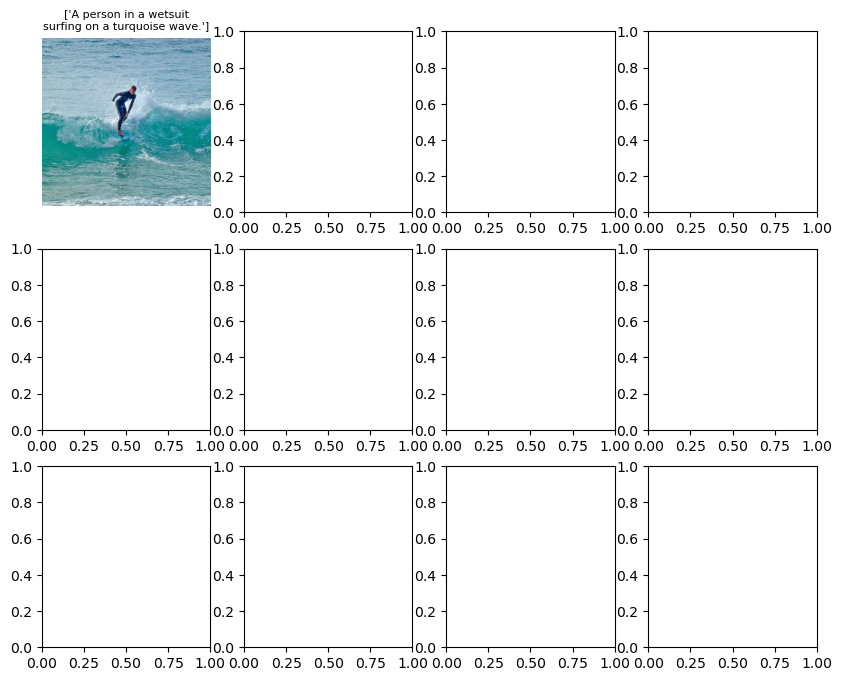

In [12]:
# 2 / 117 / 231 / 164 / 619 / 791
import textwrap
def wrap_title(title, wrap_width):
    return "\n".join(textwrap.wrap(title, wrap_width))

fig, axes = plt.subplots(3, 4, figsize=(10, 8))
jj=-1; kk=0;
for j in np.array([2,165,119,619,231,791]):
    jj+=1
    # print(kk,jj)
    axes[kk][jj].imshow(utils.torch_to_Image(all_images[j]))
    axes[kk][jj].axis('off')
    axes[kk][jj].set_title(wrap_title(str(all_captions[[j]]),wrap_width=30), fontsize=8)
    jj+=1
    axes[kk][jj].imshow(utils.torch_to_Image(all_recons[j]))
    axes[kk][jj].axis('off')
    axes[kk][jj].set_title(wrap_title(str(all_predcaptions[[j]]),wrap_width=30), fontsize=8)
    if jj==3: 
        kk+=1; jj=-1

In [10]:
# f = h5py.File(f'{data_path}/coco_images_224_float16.hdf5', 'r')
# images = f['images']
# utils.torch_to_Image(torch.Tensor(images[14].astype(np.float32)))

# Retrieval eval

In [7]:
# Load embedding model
clip_img_embedder = FrozenOpenCLIPImageEmbedder(
    arch="ViT-bigG-14",
    version="laion2b_s39b_b160k",
    output_tokens=True,
    only_tokens=True,
)
clip_img_embedder.to(device)

clip_seq_dim = 256
clip_emb_dim = 1664

In [8]:
from scipy import stats
percent_correct_fwds, percent_correct_bwds = [], []
percent_correct_fwd, percent_correct_bwd = None, None

with torch.cuda.amp.autocast(dtype=torch.float16):
    for test_i, loop in enumerate(tqdm(range(30))):
        random_samps = np.random.choice(np.arange(len(all_images)), size=300, replace=False)
        emb = clip_img_embedder(all_images[random_samps].to(device)).float() # CLIP-Image

        emb_ = all_clipvoxels[random_samps] # CLIP-Brain

        # flatten if necessary
        emb = emb.reshape(len(emb),-1)
        emb_ = emb_.reshape(len(emb_),-1)

        # l2norm 
        emb = nn.functional.normalize(emb,dim=-1)
        emb_ = nn.functional.normalize(emb_,dim=-1)

        labels = torch.arange(len(emb)).to(device)
        bwd_sim = utils.batchwise_cosine_similarity(emb,emb_)  # clip, brain
        fwd_sim = utils.batchwise_cosine_similarity(emb_,emb)  # brain, clip

        assert len(bwd_sim) == 300

        percent_correct_fwds = np.append(percent_correct_fwds, utils.topk(fwd_sim, labels,k=1).item())
        percent_correct_bwds = np.append(percent_correct_bwds, utils.topk(bwd_sim, labels,k=1).item())

        if test_i==0:
            print("Loop 0:",percent_correct_fwds, percent_correct_bwds)
            
percent_correct_fwd = np.mean(percent_correct_fwds)
fwd_sd = np.std(percent_correct_fwds) / np.sqrt(len(percent_correct_fwds))
fwd_ci = stats.norm.interval(0.95, loc=percent_correct_fwd, scale=fwd_sd)

percent_correct_bwd = np.mean(percent_correct_bwds)
bwd_sd = np.std(percent_correct_bwds) / np.sqrt(len(percent_correct_bwds))
bwd_ci = stats.norm.interval(0.95, loc=percent_correct_bwd, scale=bwd_sd)

print(f"fwd percent_correct: {percent_correct_fwd:.4f} 95% CI: [{fwd_ci[0]:.4f},{fwd_ci[1]:.4f}]")
print(f"bwd percent_correct: {percent_correct_bwd:.4f} 95% CI: [{bwd_ci[0]:.4f},{bwd_ci[1]:.4f}]")

fwd_sim = np.array(fwd_sim.cpu())
bwd_sim = np.array(bwd_sim.cpu())

  3%|███▊                                                                                                               | 1/30 [00:09<04:38,  9.59s/it]

Loop 0: [0.9066667] [0.74333334]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [01:12<00:00,  2.43s/it]

fwd percent_correct: 0.9173 95% CI: [0.9132,0.9215]
bwd percent_correct: 0.7540 95% CI: [0.7457,0.7623]


Given Brain embedding, find correct Image embedding


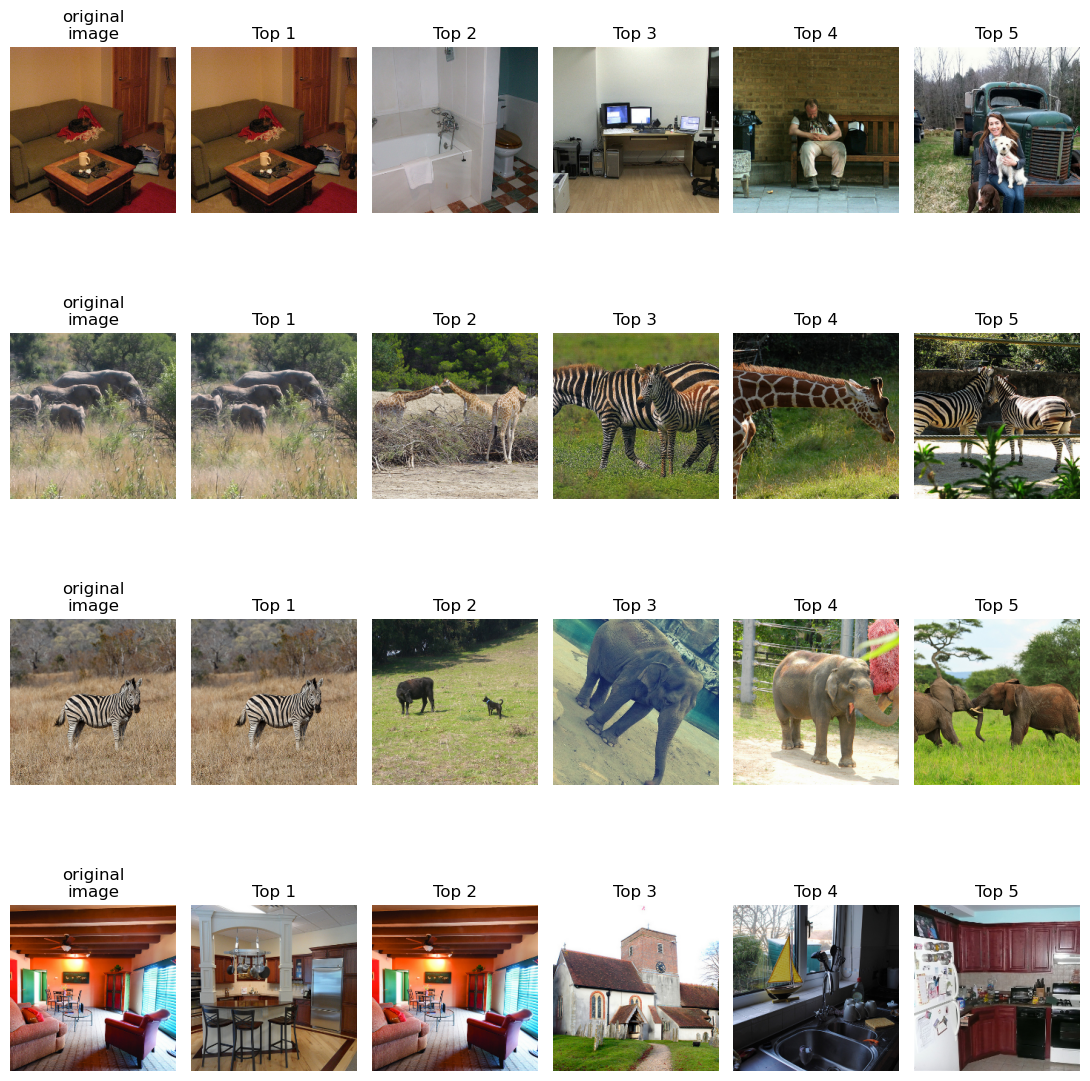

In [15]:
print("Given Brain embedding, find correct Image embedding")
fig, ax = plt.subplots(nrows=4, ncols=6, figsize=(11,12))
for trial in range(4):
    ax[trial, 0].imshow(utils.torch_to_Image(all_images[random_samps][trial]))
    ax[trial, 0].set_title("original\nimage")
    ax[trial, 0].axis("off")
    for attempt in range(5):
        which = np.flip(np.argsort(fwd_sim[trial]))[attempt]
        ax[trial, attempt+1].imshow(utils.torch_to_Image(all_images[random_samps][which]))
        ax[trial, attempt+1].set_title(f"Top {attempt+1}")
        ax[trial, attempt+1].axis("off")
fig.tight_layout()
plt.show()

## 2-way identification

In [41]:
from torchvision.models.feature_extraction import create_feature_extractor, get_graph_node_names

@torch.no_grad()
def two_way_identification(all_recons, all_images, model, preprocess, feature_layer=None, return_avg=True):
    preds = model(torch.stack([preprocess(recon) for recon in all_recons], dim=0).to(device))
    reals = model(torch.stack([preprocess(indiv) for indiv in all_images], dim=0).to(device))
    if feature_layer is None:
        preds = preds.float().flatten(1).cpu().numpy()
        reals = reals.float().flatten(1).cpu().numpy()
    else:
        preds = preds[feature_layer].float().flatten(1).cpu().numpy()
        reals = reals[feature_layer].float().flatten(1).cpu().numpy()

    r = np.corrcoef(reals, preds)
    r = r[:len(all_images), len(all_images):]
    congruents = np.diag(r)

    success = r < congruents
    success_cnt = np.sum(success, 0)

    if return_avg:
        perf = np.mean(success_cnt) / (len(all_images)-1)
        return perf
    else:
        return success_cnt, len(all_images)-1

## PixCorr

In [42]:
preprocess = transforms.Compose([
    transforms.Resize(425, interpolation=transforms.InterpolationMode.BILINEAR),
])

# Flatten images while keeping the batch dimension
all_images_flattened = preprocess(all_images).reshape(len(all_images), -1).cpu()
all_recons_flattened = preprocess(all_recons).view(len(all_recons), -1).cpu()

print(all_images_flattened.shape)
print(all_recons_flattened.shape)

corrsum = 0
for i in tqdm(range(len(all_images))):
    corrsum += np.corrcoef(all_images_flattened[i], all_recons_flattened[i])[0][1]
corrmean = corrsum / len(all_images)

pixcorr = corrmean
print(pixcorr)

torch.Size([1000, 541875])
torch.Size([1000, 541875])


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 206.23it/s]

0.09749359922789087


## SSIM

In [43]:
# see https://github.com/zijin-gu/meshconv-decoding/issues/3
from skimage.color import rgb2gray
from skimage.metrics import structural_similarity as ssim

preprocess = transforms.Compose([
    transforms.Resize(425, interpolation=transforms.InterpolationMode.BILINEAR), 
])

# convert image to grayscale with rgb2grey
img_gray = rgb2gray(preprocess(all_images).permute((0,2,3,1)).cpu())
recon_gray = rgb2gray(preprocess(all_recons).permute((0,2,3,1)).cpu())
print("converted, now calculating ssim...")

ssim_score=[]
for im,rec in tqdm(zip(img_gray,recon_gray),total=len(all_images)):
    ssim_score.append(ssim(rec, im, multichannel=True, gaussian_weights=True, sigma=1.5, use_sample_covariance=False, data_range=1.0))

ssim = np.mean(ssim_score)
print(ssim)

converted, now calculating ssim...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 73.41it/s]

0.28930491267076514


## AlexNet

In [44]:
from torchvision.models import alexnet, AlexNet_Weights
alex_weights = AlexNet_Weights.IMAGENET1K_V1

alex_model = create_feature_extractor(alexnet(weights=alex_weights), return_nodes=['features.4','features.11']).to(device)
alex_model.eval().requires_grad_(False)

# see alex_weights.transforms()
preprocess = transforms.Compose([
    transforms.Resize(256, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

layer = 'early, AlexNet(2)'
print(f"\n---{layer}---")
all_per_correct = two_way_identification(all_recons.to(device).float(), all_images, 
                                                          alex_model, preprocess, 'features.4')
alexnet2 = np.mean(all_per_correct)
print(f"2-way Percent Correct: {alexnet2:.4f}")

layer = 'mid, AlexNet(5)'
print(f"\n---{layer}---")
all_per_correct = two_way_identification(all_recons.to(device).float(), all_images, 
                                                          alex_model, preprocess, 'features.11')
alexnet5 = np.mean(all_per_correct)
print(f"2-way Percent Correct: {alexnet5:.4f}")


---early, AlexNet(2)---
2-way Percent Correct: 0.6959

---mid, AlexNet(5)---
2-way Percent Correct: 0.8031


## InceptionV3

In [45]:
from torchvision.models import inception_v3, Inception_V3_Weights
weights = Inception_V3_Weights.DEFAULT
inception_model = create_feature_extractor(inception_v3(weights=weights), 
                                           return_nodes=['avgpool']).to(device)
inception_model.eval().requires_grad_(False)

# see weights.transforms()
preprocess = transforms.Compose([
    transforms.Resize(342, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

all_per_correct = two_way_identification(all_recons, all_images,
                                        inception_model, preprocess, 'avgpool')
        
inception = np.mean(all_per_correct)
print(f"2-way Percent Correct: {inception:.4f}")

2-way Percent Correct: 0.7514


## CLIP

In [46]:
import clip
clip_model, preprocess = clip.load("ViT-L/14", device=device)

preprocess = transforms.Compose([
    transforms.Resize(224, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                         std=[0.26862954, 0.26130258, 0.27577711]),
])

all_per_correct = two_way_identification(all_recons, all_images,
                                        clip_model.encode_image, preprocess, None) # final layer
clip_ = np.mean(all_per_correct)
print(f"2-way Percent Correct: {clip_:.4f}")

2-way Percent Correct: 0.6802


## Efficient Net

In [27]:
import scipy as sp
from torchvision.models import efficientnet_b1, EfficientNet_B1_Weights
weights = EfficientNet_B1_Weights.DEFAULT
eff_model = create_feature_extractor(efficientnet_b1(weights=weights), 
                                    return_nodes=['avgpool'])
eff_model.eval().requires_grad_(False)

# see weights.transforms()
preprocess = transforms.Compose([
    transforms.Resize(255, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

gt = eff_model(preprocess(all_images))['avgpool']
gt = gt.reshape(len(gt),-1).cpu().numpy()
fake = eff_model(preprocess(all_recons))['avgpool']
fake = fake.reshape(len(fake),-1).cpu().numpy()

effnet = np.array([sp.spatial.distance.correlation(gt[i],fake[i]) for i in range(len(gt))]).mean()
print("Distance:",effnet)

Distance: 0.8863654003180418


## SwAV

In [28]:
swav_model = torch.hub.load('facebookresearch/swav:main', 'resnet50')
swav_model = create_feature_extractor(swav_model, 
                                    return_nodes=['avgpool'])
swav_model.eval().requires_grad_(False)

preprocess = transforms.Compose([
    transforms.Resize(224, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

gt = swav_model(preprocess(all_images))['avgpool']
gt = gt.reshape(len(gt),-1).cpu().numpy()
fake = swav_model(preprocess(all_recons))['avgpool']
fake = fake.reshape(len(fake),-1).cpu().numpy()

swav = np.array([sp.spatial.distance.correlation(gt[i],fake[i]) for i in range(len(gt))]).mean()
print("Distance:",swav)

Using cache found in /admin/home-mihirneal/.cache/torch/hub/facebookresearch_swav_main
/admin/home-mihirneal/miniconda3/envs/mindeye/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/admin/home-mihirneal/miniconda3/envs/mindeye/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Distance: 0.5347343630939722


# Brain Correlation
### Load brain data, brain masks, image lists

In [29]:
# Load brain data as ground truth
def my_split_by_node(urls): return urls

voxels = {}
# Load hdf5 data for betas
f = h5py.File(f'{data_path}/betas_all_subj0{subj}_fp32_renorm.hdf5', 'r')
betas = f['betas'][:]
betas = torch.Tensor(betas).to("cpu")
f.close()
num_voxels = betas[0].shape[-1]
voxels[f'subj0{subj}'] = betas
print(f"num_voxels for subj0{subj}: {num_voxels}")

if subj==3:
    num_test=2371
elif subj==4:
    num_test=2188
elif subj==6:
    num_test=2371
elif subj==8:
    num_test=2188
else:
    num_test=3000
test_url = f"{data_path}/wds/subj0{subj}/new_test/" + "0.tar"
    
print(test_url)
test_data = wds.WebDataset(test_url,resampled=False,nodesplitter=my_split_by_node)\
                    .decode("torch")\
                    .rename(behav="behav.npy", past_behav="past_behav.npy", future_behav="future_behav.npy", olds_behav="olds_behav.npy")\
                    .to_tuple(*["behav", "past_behav", "future_behav", "olds_behav"])
test_dl = torch.utils.data.DataLoader(test_data, batch_size=num_test, shuffle=False, drop_last=True, pin_memory=True)
print(f"Loaded test dl for subj{subj}!\n")

num_voxels for subj01: 15724
/weka/proj-fmri/shared/mindeyev2_dataset/wds/subj01/new_test/0.tar
Loaded test dl for subj1!



In [30]:
# Prep test voxels and indices of test images
test_images_idx = []
for test_i, (behav, past_behav, future_behav, old_behav) in enumerate(test_dl):
    test_voxels = voxels[f'subj0{subj}'][behav[:,0,5].cpu().long()]
    test_images_idx = np.append(test_images_idx, behav[:,0,0].cpu().numpy())
test_images_idx = test_images_idx.astype(int)

assert (test_i+1) * num_test == len(test_voxels) == len(test_images_idx)
print(test_i, len(test_voxels), len(test_images_idx), len(np.unique(test_images_idx)))

0 3000 3000 1000


In [31]:
# Load brain region masks
brain_region_masks = {}
brain_data = "/weka/proj-fmri/shared/mindeyev2_dataset/brain_region_masks.hdf5"
with h5py.File(brain_data, "r") as file:
    # Iterate over each subject
    for subject in file.keys():
        subject_group = file[subject]
        # Load the masks data for each subject
        subject_masks = {"nsd_general" : subject_group["nsd_general"][:],
                         "V1" : subject_group["V1"][:], 
                         "V2" : subject_group["V2"][:], 
                         "V3" : subject_group["V3"][:], 
                         "V4" : subject_group["V4"][:],
                         "higher_vis" : subject_group["higher_vis"][:]}
        brain_region_masks[subject] = subject_masks
subject_masks = brain_region_masks[f"subj0{subj}"]

# Average voxels of test set across trial repetitions for brain correlation scores
test_voxels_averaged = torch.zeros((len(np.unique(test_images_idx)),num_voxels))
# i = 0
uniq_imgs = np.unique(test_images_idx)
for i, uniq_img in enumerate(uniq_imgs):
    locs = np.where(test_images_idx==uniq_img)[0]
    if len(locs)==1:
        locs = locs.repeat(3)
    elif len(locs)==2:
        locs = locs.repeat(2)[:3]
    assert len(locs)==3
    test_voxels_averaged[i] = torch.mean(test_voxels[None,locs], dim=1)

# Prepare image list for input to GNet
recon_list = []
for i in range(all_recons.shape[0]):
    img = all_recons[i].detach()
    img = transforms.ToPILImage()(img)
    recon_list.append(img)

### Calculate Brain Correlation scores for each brain area

In [32]:
from torchmetrics import PearsonCorrCoef
GNet = GNet8_Encoder(device=device,subject=subj)
PeC = PearsonCorrCoef(num_outputs=len(recon_list))
beta_primes = GNet.predict(recon_list)

region_brain_correlations = {}
for region, mask in subject_masks.items():
    score = PeC(test_voxels_averaged[:,mask].moveaxis(0,1), beta_primes[:,mask].moveaxis(0,1))
    region_brain_correlations[region] = float(torch.mean(score))
print(region_brain_correlations)

{'nsd_general': 0.218793585896492, 'V1': 0.12271390110254288, 'V2': 0.13005182147026062, 'V3': 0.13658520579338074, 'V4': 0.14654895663261414, 'higher_vis': 0.24598532915115356}


In [49]:
# Create a dictionary to store variable names and their corresponding values
import pandas as pd
data = {
    "Metric": ["PixCorr", "SSIM", "AlexNet(2)", "AlexNet(5)", "InceptionV3", "CLIP", "EffNet-B", "SwAV", "FwdRetrieval", "BwdRetrieval",
               "Brain Corr. nsd_general", "Brain Corr. V1", "Brain Corr. V2", "Brain Corr. V3", "Brain Corr. V4",  "Brain Corr. higher_vis"],
    "Value": [pixcorr, ssim, alexnet2, alexnet5, inception, clip_, effnet, swav, percent_correct_fwd, percent_correct_bwd, 
              region_brain_correlations["nsd_general"], region_brain_correlations["V1"], region_brain_correlations["V2"], region_brain_correlations["V3"], region_brain_correlations["V4"], region_brain_correlations["higher_vis"]]}

df = pd.DataFrame(data)
print(model_name_plus_suffix)
print(df.to_string(index=False))
print(df["Value"].to_string(index=False))

# save table to txt file
os.makedirs('tables/',exist_ok=True)
df["Value"].to_csv(f'tables/{model_name_plus_suffix}.csv', sep='\t', index=False)

only_prior_all_recons
                 Metric    Value
                PixCorr 0.097494
                   SSIM 0.289305
             AlexNet(2) 0.695912
             AlexNet(5) 0.803108
            InceptionV3 0.751393
                   CLIP 0.680177
               EffNet-B 0.886365
                   SwAV 0.534734
           FwdRetrieval 0.002556
           BwdRetrieval 0.002778
Brain Corr. nsd_general 0.218794
         Brain Corr. V1 0.122714
         Brain Corr. V2 0.130052
         Brain Corr. V3 0.136585
         Brain Corr. V4 0.146549
 Brain Corr. higher_vis 0.245985
0.097494
0.289305
0.695912
0.803108
0.751393
0.680177
0.886365
0.534734
0.002556
0.002778
0.218794
0.122714
0.130052
0.136585
0.146549
0.245985


# Captions evaluation

## BLEU

In [29]:
bleu=evaluate.load("bleu")
bleu_img_ref=bleu.compute(predictions=all_git_generated_captions,references=all_captions,max_order=1)
bleu_brain_ref=bleu.compute(predictions=all_predcaptions,references=all_captions,max_order=1)
bleu_brain_img=bleu.compute(predictions=all_predcaptions,references=all_git_generated_captions,max_order=1)

bleu_img_ref_4=bleu.compute(predictions=all_git_generated_captions,references=all_captions,max_order=4)
bleu_brain_ref_4=bleu.compute(predictions=all_predcaptions,references=all_captions,max_order=4)
bleu_brain_img_4=bleu.compute(predictions=all_predcaptions,references=all_git_generated_captions,max_order=4)



relative_brain_image_bleu=bleu_brain_img["bleu"]/bleu_img_ref["bleu"]
relative_brain_image_bleu_4=bleu_brain_img_4["bleu"]/bleu_img_ref_4["bleu"]


print(f"[GROUND] BLEU@1 GIT from images vs captions: {bleu_img_ref['bleu']}")
print(f"[ABSOLUTE] BLEU@1 GIT from brain vs captions: {bleu_brain_ref['bleu']}")
print(f"[ABSOLUTE] BLEU@1 GIT from brain vs images: {bleu_brain_img['bleu']}")
print(f"[RELATIVE] BLEU@1  {relative_brain_image_bleu}")


print(f"[GROUND] BLEU@4 GIT from images vs captions: {bleu_img_ref_4['bleu']}")
print(f"[ABSOLUTE] BLEU@4 GIT from brain vs captions: {bleu_brain_ref_4['bleu']}")
print(f"[ABSOLUTE] BLEU@4 GIT from brain vs images: {bleu_brain_img_4['bleu']}")
print(f"[RELATIVE] BLEU@4  {relative_brain_image_bleu_4}")

[GROUND] BLEU@1 GIT from images vs captions: 0.4571830939217121
[ABSOLUTE] BLEU@1 GIT from brain vs captions: 0.22184573253396753
[ABSOLUTE] BLEU@1 GIT from brain vs images: 0.32617668355650475
[RELATIVE] BLEU@1  0.7134486989852673
[GROUND] BLEU@4 GIT from images vs captions: 0.1464970991440656
[ABSOLUTE] BLEU@4 GIT from brain vs captions: 0.024498008023317797
[ABSOLUTE] BLEU@4 GIT from brain vs images: 0.051335260532570454
[RELATIVE] BLEU@4  0.35041827334811065


## Meteor

In [30]:
meteor = evaluate.load('meteor')
meteor_img_ref=meteor.compute(predictions=all_git_generated_captions,references=all_captions)
meteor_brain_ref=meteor.compute(predictions=all_predcaptions,references=all_captions)
meteor_brain_img=meteor.compute(predictions=all_predcaptions,references=all_git_generated_captions)


relative_brain_image_meteor=meteor_brain_img["meteor"]/meteor_img_ref["meteor"]

print(f"[GROUND] METEOR GIT from images vs captions: {meteor_img_ref['meteor']}")
print(f"[ABSOLUTE] METEOR GIT from brain vs captions: {meteor_brain_ref['meteor']}")
print(f"[ABSOLUTE] METEOR GIT from brain vs images: {meteor_brain_img['meteor']}")
print(f"[RELATIVE] METEOR  {relative_brain_image_meteor}")

[nltk_data] Downloading package wordnet to /admin/home-
[nltk_data]     mihirneal/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /admin/home-
[nltk_data]     mihirneal/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /admin/home-
[nltk_data]     mihirneal/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


[GROUND] METEOR GIT from images vs captions: 0.4196759954156638
[ABSOLUTE] METEOR GIT from brain vs captions: 0.17569615441636063
[ABSOLUTE] METEOR GIT from brain vs images: 0.22326257289958576
[RELATIVE] METEOR  0.5319879510346014


## Rouge

In [31]:
rouge = evaluate.load('rouge')
rouge_img_ref=rouge.compute(predictions=all_git_generated_captions,references=all_captions)
rouge_brain_ref=rouge.compute(predictions=all_predcaptions,references=all_captions)
rouge_brain_img=rouge.compute(predictions=all_predcaptions,references=all_git_generated_captions)


relative_brain_image_rouge1 = rouge_brain_img['rouge1']/rouge_img_ref['rouge1']
relative_brain_image_rougeL = rouge_brain_img['rougeL']/rouge_img_ref['rougeL']

print(f"[GROUND] ROUGE-1 GIT from images vs captions: {rouge_img_ref['rouge1']}")
print(f"[ABSOLUTE] ROUGE-1 GIT from brain vs captions: {rouge_brain_ref['rouge1']}")
print(f"[ABSOLUTE] ROUGE-1 GIT from brain vs images: {rouge_brain_img['rouge1']}")
print(f"[RELATIVE] ROUGE-1  {relative_brain_image_rouge1}")

print(f"[GROUND] ROUGE-L GIT from images vs captions: {rouge_img_ref['rougeL']}")
print(f"[ABSOLUTE] ROUGE-L GIT from brain vs captions: {rouge_brain_ref['rougeL']}")
print(f"[ABSOLUTE] ROUGE-L GIT from brain vs images: {rouge_brain_img['rougeL']}")
print(f"[RELATIVE] ROUGE-L  {relative_brain_image_rougeL}")


[GROUND] ROUGE-1 GIT from images vs captions: 0.5066996914549835
[ABSOLUTE] ROUGE-1 GIT from brain vs captions: 0.27031472455765004
[ABSOLUTE] ROUGE-1 GIT from brain vs images: 0.32600642319723927
[RELATIVE] ROUGE-1  0.6433917933936665
[GROUND] ROUGE-L GIT from images vs captions: 0.46368458943691104
[ABSOLUTE] ROUGE-L GIT from brain vs captions: 0.2524810952104615
[ABSOLUTE] ROUGE-L GIT from brain vs images: 0.30960859555057185
[RELATIVE] ROUGE-L  0.6677137920985343


## Sentence transformer

In [32]:
sentence_model = SentenceTransformer('paraphrase-MiniLM-L6-v2')


with torch.no_grad():
    embedding_brain= sentence_model.encode(all_predcaptions, convert_to_tensor=True)
    embedding_captions = sentence_model.encode(all_captions, convert_to_tensor=True)
    embedding_images = sentence_model.encode(all_git_generated_captions, convert_to_tensor=True)

    ss_sim_brain_img=util.pytorch_cos_sim(embedding_brain, embedding_images).cpu()
    ss_sim_brain_cap=util.pytorch_cos_sim(embedding_brain, embedding_captions).cpu()
    ss_sim_img_cap=util.pytorch_cos_sim(embedding_images, embedding_captions).cpu()

    relative_brain_image_ss=ss_sim_brain_img.diag().mean()/ss_sim_img_cap.diag().mean()

/admin/home-mihirneal/miniconda3/envs/mindeye/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [33]:
print(f"[GROUND] Sentence Transformer Similarity GIT from images vs captions: {ss_sim_img_cap.diag().mean()}")
print(f"[ABSOLUTE] Sentence Transformer Similarity GIT from brain vs captions: {ss_sim_brain_cap.diag().mean()}")
print(f"[ABSOLUTE] Sentence Transformer Similarity GIT from brain vs images: {ss_sim_brain_img.diag().mean()}")
print(f"[RELATIVE] Sentence Transformer Similarity   {relative_brain_image_ss.mean()}")

[GROUND] Sentence Transformer Similarity GIT from images vs captions: 0.7542507648468018
[ABSOLUTE] Sentence Transformer Similarity GIT from brain vs captions: 0.2298625409603119
[ABSOLUTE] Sentence Transformer Similarity GIT from brain vs images: 0.22942139208316803
[RELATIVE] Sentence Transformer Similarity   0.30417123436927795


## CLIP

In [34]:
model_clip = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor_clip = AutoProcessor.from_pretrained("openai/clip-vit-base-patch32")
tokenizer =  AutoTokenizer.from_pretrained("openai/clip-vit-base-patch32")

with torch.no_grad():
    input_ids=tokenizer(list(all_predcaptions),return_tensors="pt",padding=True)
    embedding_brain= model_clip.get_text_features(**input_ids)

    input_ids=tokenizer(list(all_captions),return_tensors="pt",padding=True)
    embedding_captions= model_clip.get_text_features(**input_ids)

    input_ids=tokenizer(all_git_generated_captions,return_tensors="pt",padding=True)
    embedding_images= model_clip.get_text_features(**input_ids)

clip_sim_brain_img=util.pytorch_cos_sim(embedding_brain, embedding_images).cpu()
clip_sim_brain_cap=util.pytorch_cos_sim(embedding_brain, embedding_captions).cpu()
clip_sim_img_cap=util.pytorch_cos_sim(embedding_images, embedding_captions).cpu()

relative_brain_image_clip=clip_sim_brain_img.diag().mean()/clip_sim_img_cap.diag().mean()

print(f"[GROUND] CLIP Similarity GIT from images vs captions: {clip_sim_img_cap.diag().mean()}")
print(f"[ABSOLUTE] CLIP Similarity GIT from brain vs captions: {clip_sim_brain_cap.diag().mean()}")
print(f"[ABSOLUTE] CLIP Similarity GIT from brain vs images: {clip_sim_brain_img.diag().mean()}")
print(f"[RELATIVE] CLIP Similarity   {relative_brain_image_clip.mean()}")

[GROUND] CLIP Similarity GIT from images vs captions: 0.8392383456230164
[ABSOLUTE] CLIP Similarity GIT from brain vs captions: 0.6361596584320068
[ABSOLUTE] CLIP Similarity GIT from brain vs images: 0.6415414810180664
[RELATIVE] CLIP Similarity   0.764432966709137


In [35]:

caption_metrics={  
            "Bleu_1_img_ref": bleu_img_ref['bleu'],
            "Blue_1_brain_ref": bleu_brain_ref['bleu'],
            "Bleu_1_brain_img": bleu_brain_img['bleu'],
            "Bleu_1_relative": relative_brain_image_bleu,
            "Bleu_4_img_ref": bleu_img_ref_4['bleu'],
            "Blue_4_brain_ref": bleu_brain_ref_4['bleu'],
            "Bleu_4_brain_img": bleu_brain_img_4['bleu'],
            "Bleu_4_relative": relative_brain_image_bleu_4,
            "Rouge1_img_ref":rouge_img_ref['rouge1'],
            "Rouge1_brain_ref":rouge_brain_ref['rouge1'],
            "Rouge1_brain_img":rouge_brain_img['rouge1'],
            "Rouge1_relative":relative_brain_image_rouge1.mean(),
            "RougeL_img_ref":rouge_img_ref['rougeL'],
            "RougeL_brain_ref":rouge_brain_ref['rougeL'],
            "RougeL_brain_img":rouge_brain_img['rougeL'],
            "RougeL_relative":relative_brain_image_rougeL.mean(),
            "Meteor_img_ref":meteor_img_ref['meteor'],
            "Meteor_brain_ref":meteor_brain_ref['meteor'],
            "Meteor_brain_img":meteor_brain_img['meteor'],
            "Meteor_relative":relative_brain_image_meteor,
            "Sentence_img_ref":ss_sim_img_cap.diag().mean().item(),
            "Sentence_brain_ref":ss_sim_brain_cap.diag().mean().item(),
            "Sentence_brain_img":ss_sim_brain_img.diag().mean().item(),
            "Sentence_relative":relative_brain_image_ss.mean().item(),
            "CLIP_img_ref":clip_sim_img_cap.diag().mean().item(),
            "CLIP_brain_ref":clip_sim_brain_cap.diag().mean().item(),
            "CLIP_brain_img":clip_sim_brain_img.diag().mean().item(),
            "CLIP_relative":relative_brain_image_clip.mean().item()}

df=pd.DataFrame.from_dict(caption_metrics,orient='index',columns=["Value"])

df.to_csv(f'tables/{model_name_plus_suffix}_caption_metrics.csv', sep='\t', index=False)
